In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, BatchNormalization, Dense, MaxPooling2D, AveragePooling2D, Activation, Input, Add
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def get_data():
    from keras.datasets import cifar10
    (X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()
    
    X_train_full = X_train_full.astype(float)
    X_test = X_test.astype(float)
    
    X_train = X_train_full / 255.0
    X_test = X_test / 255.0
    
    y_train_full = to_categorical(y_train_full)
    y_test = to_categorical(y_test)
    
    X_train, X_valid = X_train[5000:], X_train[:5000]
    y_train, y_valid = y_train_full[5000:], y_train_full[:5000]
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [3]:
def data_augmentation(X_train, X_valid, X_test, y_train, y_valid, y_test):
    train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)
    
    test_datagen = ImageDataGenerator()
    
    train_generator = train_datagen.flow(X_train, y_train,
                                         batch_size = 64)
    validation_generator = test_datagen.flow(X_valid, y_valid, batch_size = 64)
    test_generator = test_datagen.flow(X_test, y_test, batch_size = 64)
    
    return train_generator, validation_generator, test_generator

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data()
train_generator, validation_generator, test_generator = data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test)

### Model Architecture 1

In [17]:
def identity_block(inputs, filters):
    hlayer = Conv2D(filters = filters[0], kernel_size = (1, 1), padding = "same", kernel_initializer = "he_uniform")(inputs)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = Conv2D(filters = filters[1], kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(hlayer)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = Conv2D(filters = filters[2], kernel_size = (1, 1), padding = "same", kernel_initializer = "he_uniform")(hlayer)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Add()([hlayer, inputs])
    out = Activation("relu")(hlayer)
    return out

def conv_block(inputs, s, filters):
    hlayer = Conv2D(filters = filters[0] , kernel_size = (1, 1), strides = (s, s), padding = "same", kernel_initializer = "he_uniform")(inputs)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = Conv2D(filters = filters[1] , kernel_size = (3, 3), strides = (1, 1), padding = "same", kernel_initializer = "he_uniform")(hlayer)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = Conv2D(filters = filters[2] , kernel_size = (1, 1), strides = (1, 1), padding = "same", kernel_initializer = "he_uniform")(hlayer)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    
    inputs = Conv2D(filters = filters[2] , kernel_size = (1, 1), padding = "same", strides = (s, s), kernel_initializer = "he_uniform")(inputs)
    inputs = BatchNormalization(axis = 3)(inputs)
    hlayer = Add()([hlayer, inputs])
    out = Activation("relu")(hlayer)
    return out
    
def resnet_model(loss, optimizer, metrics, input_shape = (32, 32, 3)):
    X_input = Input(input_shape)
    hlayer = Conv2D(filters = 32, kernel_size = (7, 7), strides = (1, 1), padding = "same", kernel_initializer = "he_uniform")(X_input)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = MaxPooling2D((3, 3))(hlayer)
    
    hlayer = conv_block(hlayer, s = 1, filters = [32, 32, 128])
    
    hlayer = identity_block(hlayer, filters = [32, 32, 128])
    hlayer = identity_block(hlayer, filters = [32, 32, 128])
    hlayer = identity_block(hlayer, filters = [32, 32, 128])
    
    hlayer = conv_block(hlayer, s = 2, filters = [64, 64, 256])
    
    hlayer = identity_block(hlayer, filters = [64, 64, 256])
    hlayer = identity_block(hlayer, filters = [64, 64, 256])
    hlayer = identity_block(hlayer, filters = [64, 64, 256])
    
    hlayer = conv_block(hlayer, s = 2, filters = [128, 128, 512])
    
    hlayer = identity_block(hlayer, filters = [128, 128, 512])
    hlayer = identity_block(hlayer, filters = [128, 128, 512])
    hlayer = identity_block(hlayer, filters = [128, 128, 512])
    hlayer = identity_block(hlayer, filters = [128, 128, 512])
    hlayer = identity_block(hlayer, filters = [128, 128, 512])
    
    hlayer = conv_block(hlayer, s = 2, filters = [256, 256, 1024])
    
    hlayer = identity_block(hlayer, filters = [256, 256, 1024])
    hlayer = identity_block(hlayer, filters = [256, 256, 1024])
    
    hlayer = AveragePooling2D((2, 2))(hlayer)
    
    hlayer = Flatten()(hlayer)
    
    hlayer = Dense(2048, activation = "relu", kernel_initializer =  "he_uniform")(hlayer)
    out = Dense(10, activation = "softmax")(hlayer)
    
    model = Model(inputs = X_input, outputs = out)
    
    model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
    return model

In [18]:
loss = "categorical_crossentropy"
optimizer = Adam(learning_rate = 0.003)
metrics = ["accuracy"]
model2 = resnet_model(loss = loss, optimizer = optimizer, metrics = metrics, input_shape = (32, 32, 3))
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 32, 32, 32)   4736        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, 32, 32, 32)   128         conv2d_124[0][0]                 
__________________________________________________________________________________________________
activation_116 (Activation)     (None, 32, 32, 32)   0           batch_normalization_124[0][0]    
____________________________________________________________________________________________

In [20]:
callbacks = keras.callbacks.ModelCheckpoint("Best_resnet2.h5", save_best_only = True)
history2 = model2.fit(train_generator,
                     steps_per_epoch = X_train.shape[0] // 64,
                     validation_data = validation_generator,
                     epochs = 300,
                     callbacks = [callbacks])

Epoch 1/300
703/703 [==============================] - 57s 59ms/step - loss: 2.4226 - accuracy: 0.1839 - val_loss: 1.9721 - val_accuracy: 0.2688
Epoch 2/300
703/703 [==============================] - 41s 59ms/step - loss: 1.9148 - accuracy: 0.2751 - val_loss: 2.4952 - val_accuracy: 0.2602
Epoch 3/300
703/703 [==============================] - 41s 59ms/step - loss: 1.8202 - accuracy: 0.3210 - val_loss: 2.2419 - val_accuracy: 0.3706
Epoch 4/300
703/703 [==============================] - 41s 59ms/step - loss: 1.7313 - accuracy: 0.3620 - val_loss: 2.0108 - val_accuracy: 0.2906
Epoch 5/300
703/703 [==============================] - 41s 59ms/step - loss: 1.7078 - accuracy: 0.3696 - val_loss: 3.5660 - val_accuracy: 0.1518
Epoch 6/300
703/703 [==============================] - 41s 59ms/step - loss: 1.8351 - accuracy: 0.3269 - val_loss: 2.4822 - val_accuracy: 0.1572
Epoch 7/300
703/703 [==============================] - 46s 66ms/step - loss: 1.8210 - accuracy: 0.3350 - val_loss: 2.2134 - val_ac

703/703 [==============================] - 41s 58ms/step - loss: 0.7074 - accuracy: 0.7565 - val_loss: 0.9442 - val_accuracy: 0.7076
Epoch 114/300
703/703 [==============================] - 41s 58ms/step - loss: 0.6900 - accuracy: 0.7607 - val_loss: 1.0578 - val_accuracy: 0.7272
Epoch 115/300
703/703 [==============================] - 41s 58ms/step - loss: 0.7028 - accuracy: 0.7558 - val_loss: 0.7160 - val_accuracy: 0.7658
Epoch 116/300
703/703 [==============================] - 41s 59ms/step - loss: 0.6981 - accuracy: 0.7601 - val_loss: 0.9985 - val_accuracy: 0.7802
Epoch 117/300
703/703 [==============================] - 42s 59ms/step - loss: 0.6934 - accuracy: 0.7585 - val_loss: 0.8088 - val_accuracy: 0.7610
Epoch 118/300
703/703 [==============================] - 41s 59ms/step - loss: 0.6746 - accuracy: 0.7690 - val_loss: 0.7042 - val_accuracy: 0.7988
Epoch 119/300
703/703 [==============================] - 42s 60ms/step - loss: 0.6853 - accuracy: 0.7646 - val_loss: 0.8709 - val_ac

Epoch 169/300
703/703 [==============================] - 44s 62ms/step - loss: 0.5897 - accuracy: 0.7963 - val_loss: 0.5793 - val_accuracy: 0.8034
Epoch 170/300
703/703 [==============================] - 43s 62ms/step - loss: 0.5826 - accuracy: 0.7963 - val_loss: 0.8435 - val_accuracy: 0.7928
Epoch 171/300
703/703 [==============================] - 44s 62ms/step - loss: 0.5908 - accuracy: 0.7959 - val_loss: 0.6615 - val_accuracy: 0.7984
Epoch 172/300
703/703 [==============================] - 44s 62ms/step - loss: 0.5858 - accuracy: 0.7959 - val_loss: 0.9186 - val_accuracy: 0.7832
Epoch 173/300
703/703 [==============================] - 43s 61ms/step - loss: 0.5775 - accuracy: 0.7998 - val_loss: 0.9534 - val_accuracy: 0.7588
Epoch 174/300
703/703 [==============================] - 44s 62ms/step - loss: 0.5736 - accuracy: 0.8030 - val_loss: 0.8064 - val_accuracy: 0.8100
Epoch 175/300
703/703 [==============================] - 44s 62ms/step - loss: 0.5834 - accuracy: 0.7987 - val_loss: 1

703/703 [==============================] - 42s 60ms/step - loss: 0.4633 - accuracy: 0.8415 - val_loss: 0.7689 - val_accuracy: 0.7772
Epoch 280/300
703/703 [==============================] - 42s 60ms/step - loss: 0.4494 - accuracy: 0.8440 - val_loss: 0.5053 - val_accuracy: 0.8336
Epoch 281/300
703/703 [==============================] - 43s 61ms/step - loss: 0.4586 - accuracy: 0.8413 - val_loss: 0.4655 - val_accuracy: 0.8466
Epoch 282/300
703/703 [==============================] - 42s 60ms/step - loss: 0.4585 - accuracy: 0.8403 - val_loss: 0.8279 - val_accuracy: 0.8154
Epoch 283/300
703/703 [==============================] - 43s 61ms/step - loss: 0.4633 - accuracy: 0.8346 - val_loss: 0.6875 - val_accuracy: 0.7884
Epoch 284/300
703/703 [==============================] - 43s 61ms/step - loss: 0.4542 - accuracy: 0.8420 - val_loss: 0.7773 - val_accuracy: 0.7660
Epoch 285/300
703/703 [==============================] - 43s 61ms/step - loss: 0.4590 - accuracy: 0.8413 - val_loss: 0.4942 - val_ac

In [21]:
model2.evaluate(test_generator, steps = 32)

32/32 [==============================] - 1s 39ms/step - loss: 0.6959 - accuracy: 0.8057


[0.6959089040756226, 0.8056640625]

In [25]:
new_model = keras.models.load_model("Best_resnet2.h5")
#new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 32, 32, 32)   4736        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, 32, 32, 32)   128         conv2d_124[0][0]                 
__________________________________________________________________________________________________
activation_116 (Activation)     (None, 32, 32, 32)   0           batch_normalization_124[0][0]    
____________________________________________________________________________________________

In [26]:
new_model.evaluate(test_generator, steps = 64)

64/64 [==============================] - 3s 26ms/step - loss: 0.4528 - accuracy: 0.8433


[0.45275187492370605, 0.84326171875]

### Model Architecture 2

In [6]:
def identity_block(inputs, filters):
    hlayer = Conv2D(filters = filters[0], kernel_size = (1, 1), padding = "same", kernel_initializer = "he_uniform")(inputs)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = Conv2D(filters = filters[1], kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(hlayer)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = Conv2D(filters = filters[2], kernel_size = (1, 1), padding = "same", kernel_initializer = "he_uniform")(hlayer)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    
    hlayer = Add()([hlayer, inputs])
    out = Activation("relu")(hlayer)
    return out

def conv_block(inputs, s, filters):
    hlayer = Conv2D(filters = filters[0] , kernel_size = (1, 1), strides = (s, s), padding = "same", kernel_initializer = "he_uniform")(inputs)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = Conv2D(filters = filters[1] , kernel_size = (3, 3), strides = (1, 1), padding = "same", kernel_initializer = "he_uniform")(hlayer)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = Conv2D(filters = filters[2] , kernel_size = (1, 1), strides = (1, 1), padding = "same", kernel_initializer = "he_uniform")(hlayer)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    
    inputs = Conv2D(filters = filters[2] , kernel_size = (1, 1), padding = "same", strides = (s, s), kernel_initializer = "he_uniform")(inputs)
    inputs = BatchNormalization(axis = 3)(inputs)
    
    hlayer = Add()([hlayer, inputs])
    out = Activation("relu")(hlayer)
    return out
    
def resnet_model(loss, optimizer, metrics, input_shape = (32, 32, 3)):
    X_input = Input(input_shape)
    hlayer = Conv2D(filters = 32, kernel_size = (7, 7), strides = (1, 1), padding = "same", kernel_initializer = "he_uniform")(X_input)
    hlayer = BatchNormalization(axis = 3)(hlayer)
    hlayer = Activation("relu")(hlayer)
    hlayer = MaxPooling2D((3, 3))(hlayer)
    
    hlayer = conv_block(hlayer, s = 1, filters = [32, 32, 128])
    
    hlayer = identity_block(hlayer, filters = [32, 32, 128])
    hlayer = identity_block(hlayer, filters = [32, 32, 128])
    hlayer = Dropout(0.2)(hlayer)
    
    hlayer = conv_block(hlayer, s = 2, filters = [64, 64, 256])
    
    hlayer = identity_block(hlayer, filters = [64, 64, 256])
    hlayer = identity_block(hlayer, filters = [64, 64, 256])
    hlayer = identity_block(hlayer, filters = [64, 64, 256])
    hlayer = Dropout(0.3)(hlayer)
    
    hlayer = conv_block(hlayer, s = 2, filters = [128, 128, 512])
    
    hlayer = identity_block(hlayer, filters = [128, 128, 512])
    hlayer = identity_block(hlayer, filters = [128, 128, 512])
    hlayer = identity_block(hlayer, filters = [128, 128, 512])
    hlayer = Dropout(0.4)(hlayer)
    
    hlayer = conv_block(hlayer, s = 2, filters = [256, 256, 1024])
    
    hlayer = identity_block(hlayer, filters = [256, 256, 1024])
    hlayer = identity_block(hlayer, filters = [256, 256, 1024])
    hlayer = identity_block(hlayer, filters = [256, 256, 1024])
    hlayer = identity_block(hlayer, filters = [256, 256, 1024])
    hlayer = Dropout(0.5)(hlayer)
    
    hlayer = AveragePooling2D((2, 2))(hlayer)
    
    hlayer = Flatten()(hlayer)
    out = Dense(10, activation = "softmax")(hlayer)
    
    model = Model(inputs = X_input, outputs = out)
    
    model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
    return model

In [7]:
loss = "categorical_crossentropy"
optimizer = Adam(learning_rate = 0.003)
metrics = ["accuracy"]
model3 = resnet_model(loss, optimizer, metrics, input_shape = (32, 32, 3))
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   4736        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
callbacks = keras.callbacks.ModelCheckpoint("Best_resnet3.h5", save_best_only = True)
history3 = model3.fit(train_generator,
                     steps_per_epoch = X_train.shape[0] // 64,
                     validation_data = validation_generator,
                     epochs = 500,
                     callbacks = [callbacks])

Epoch 1/500
703/703 [==============================] - 297s 271ms/step - loss: 2.5206 - accuracy: 0.2188 - val_loss: 1.8653 - val_accuracy: 0.3340


D:\Anaconda\envs\GPU\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/500
703/703 [==============================] - 48s 69ms/step - loss: 1.9755 - accuracy: 0.3022 - val_loss: 2.4845 - val_accuracy: 0.3364
Epoch 3/500
703/703 [==============================] - 47s 67ms/step - loss: 1.7727 - accuracy: 0.3572 - val_loss: 1.7174 - val_accuracy: 0.4326
Epoch 4/500
703/703 [==============================] - 47s 67ms/step - loss: 1.6678 - accuracy: 0.3959 - val_loss: 1.6968 - val_accuracy: 0.3956
Epoch 5/500
703/703 [==============================] - 47s 66ms/step - loss: 1.5910 - accuracy: 0.4218 - val_loss: 1.5926 - val_accuracy: 0.4250
Epoch 6/500
703/703 [==============================] - 47s 66ms/step - loss: 1.5452 - accuracy: 0.4389 - val_loss: 1.9105 - val_accuracy: 0.3682
Epoch 7/500
703/703 [==============================] - 47s 66ms/step - loss: 1.5009 - accuracy: 0.4543 - val_loss: 1.5002 - val_accuracy: 0.4580
Epoch 8/500
703/703 [==============================] - 47s 67ms/step - loss: 1.4328 - accuracy: 0.4823 - val_loss: 1.3479 - val_ac

703/703 [==============================] - 47s 67ms/step - loss: 0.6073 - accuracy: 0.7930 - val_loss: 0.6011 - val_accuracy: 0.7966
Epoch 115/500
703/703 [==============================] - 47s 67ms/step - loss: 0.6335 - accuracy: 0.7855 - val_loss: 0.7633 - val_accuracy: 0.7624
Epoch 116/500
703/703 [==============================] - 47s 67ms/step - loss: 0.5954 - accuracy: 0.7964 - val_loss: 0.5706 - val_accuracy: 0.8054
Epoch 117/500
703/703 [==============================] - 47s 67ms/step - loss: 0.5917 - accuracy: 0.7972 - val_loss: 0.5458 - val_accuracy: 0.8138
Epoch 118/500
703/703 [==============================] - 47s 67ms/step - loss: 0.5860 - accuracy: 0.8004 - val_loss: 0.6662 - val_accuracy: 0.7740
Epoch 119/500
703/703 [==============================] - 47s 66ms/step - loss: 0.5952 - accuracy: 0.7986 - val_loss: 0.5711 - val_accuracy: 0.8088
Epoch 120/500
703/703 [==============================] - 47s 67ms/step - loss: 0.5851 - accuracy: 0.7994 - val_loss: 0.8845 - val_ac

Epoch 170/500
703/703 [==============================] - 48s 69ms/step - loss: 0.5137 - accuracy: 0.8246 - val_loss: 0.5986 - val_accuracy: 0.8114
Epoch 171/500
703/703 [==============================] - 46s 65ms/step - loss: 0.5053 - accuracy: 0.8290 - val_loss: 0.5971 - val_accuracy: 0.8146
Epoch 172/500
703/703 [==============================] - 48s 68ms/step - loss: 0.5113 - accuracy: 0.8235 - val_loss: 0.5066 - val_accuracy: 0.8314
Epoch 173/500
703/703 [==============================] - 49s 69ms/step - loss: 0.5321 - accuracy: 0.8180 - val_loss: 2.7287 - val_accuracy: 0.7906
Epoch 174/500
703/703 [==============================] - 47s 67ms/step - loss: 0.5385 - accuracy: 0.8158 - val_loss: 0.6230 - val_accuracy: 0.8214
Epoch 175/500
703/703 [==============================] - 49s 69ms/step - loss: 0.5066 - accuracy: 0.8263 - val_loss: 0.6184 - val_accuracy: 0.8294
Epoch 176/500
703/703 [==============================] - 48s 68ms/step - loss: 0.5027 - accuracy: 0.8303 - val_loss: 0

Epoch 226/500
703/703 [==============================] - 47s 67ms/step - loss: 0.4554 - accuracy: 0.8455 - val_loss: 0.5049 - val_accuracy: 0.8496
Epoch 227/500
703/703 [==============================] - 48s 68ms/step - loss: 0.4476 - accuracy: 0.8455 - val_loss: 0.6838 - val_accuracy: 0.8036
Epoch 228/500
703/703 [==============================] - 46s 66ms/step - loss: 0.4497 - accuracy: 0.8470 - val_loss: 0.4975 - val_accuracy: 0.8374
Epoch 229/500
703/703 [==============================] - 47s 67ms/step - loss: 0.4506 - accuracy: 0.8465 - val_loss: 0.5634 - val_accuracy: 0.8462
Epoch 230/500
703/703 [==============================] - 47s 66ms/step - loss: 0.4587 - accuracy: 0.8430 - val_loss: 0.5364 - val_accuracy: 0.8394
Epoch 231/500
703/703 [==============================] - 47s 67ms/step - loss: 0.4508 - accuracy: 0.8450 - val_loss: 0.5493 - val_accuracy: 0.8288
Epoch 232/500
703/703 [==============================] - 48s 68ms/step - loss: 0.4558 - accuracy: 0.8454 - val_loss: 0

Epoch 282/500
703/703 [==============================] - 48s 69ms/step - loss: 0.4379 - accuracy: 0.8495 - val_loss: 0.6850 - val_accuracy: 0.8440
Epoch 283/500
703/703 [==============================] - 48s 69ms/step - loss: 0.4063 - accuracy: 0.8593 - val_loss: 0.8160 - val_accuracy: 0.8576
Epoch 284/500
703/703 [==============================] - 48s 69ms/step - loss: 0.4060 - accuracy: 0.8594 - val_loss: 0.6501 - val_accuracy: 0.8540
Epoch 285/500
703/703 [==============================] - 48s 69ms/step - loss: 0.4378 - accuracy: 0.8510 - val_loss: 1.7840 - val_accuracy: 0.8488
Epoch 286/500
703/703 [==============================] - 48s 69ms/step - loss: 0.4548 - accuracy: 0.8462 - val_loss: 0.5370 - val_accuracy: 0.8314
Epoch 287/500
703/703 [==============================] - 48s 69ms/step - loss: 0.4087 - accuracy: 0.8582 - val_loss: 0.5237 - val_accuracy: 0.8554
Epoch 288/500
703/703 [==============================] - 48s 68ms/step - loss: 0.4014 - accuracy: 0.8634 - val_loss: 0

Epoch 338/500
703/703 [==============================] - 48s 69ms/step - loss: 0.3824 - accuracy: 0.8672 - val_loss: 0.4822 - val_accuracy: 0.8484
Epoch 339/500
703/703 [==============================] - 48s 68ms/step - loss: 0.3830 - accuracy: 0.8671 - val_loss: 0.4456 - val_accuracy: 0.8588
Epoch 340/500
703/703 [==============================] - 48s 68ms/step - loss: 0.3724 - accuracy: 0.8725 - val_loss: 3.5590 - val_accuracy: 0.4312
Epoch 341/500
703/703 [==============================] - 48s 68ms/step - loss: 0.4122 - accuracy: 0.8579 - val_loss: 0.4671 - val_accuracy: 0.8660
Epoch 342/500
703/703 [==============================] - 48s 68ms/step - loss: 0.3754 - accuracy: 0.8730 - val_loss: 0.5078 - val_accuracy: 0.8632
Epoch 343/500
703/703 [==============================] - 48s 69ms/step - loss: 0.3698 - accuracy: 0.8729 - val_loss: 1.0578 - val_accuracy: 0.7990
Epoch 344/500
703/703 [==============================] - 48s 69ms/step - loss: 0.3766 - accuracy: 0.8697 - val_loss: 0

703/703 [==============================] - 48s 68ms/step - loss: 0.3536 - accuracy: 0.8797 - val_loss: 2.3265 - val_accuracy: 0.8200
Epoch 449/500
703/703 [==============================] - 48s 69ms/step - loss: 0.3391 - accuracy: 0.8835 - val_loss: 0.4917 - val_accuracy: 0.8594
Epoch 450/500
703/703 [==============================] - 48s 68ms/step - loss: 0.4208 - accuracy: 0.8585 - val_loss: 0.4649 - val_accuracy: 0.8558
Epoch 451/500
703/703 [==============================] - 48s 69ms/step - loss: 0.3333 - accuracy: 0.8861 - val_loss: 0.4895 - val_accuracy: 0.8682
Epoch 452/500
703/703 [==============================] - 48s 68ms/step - loss: 0.3286 - accuracy: 0.8883 - val_loss: 0.4635 - val_accuracy: 0.8640
Epoch 453/500
703/703 [==============================] - 48s 68ms/step - loss: 0.3267 - accuracy: 0.8862 - val_loss: 0.4094 - val_accuracy: 0.8712
Epoch 454/500
703/703 [==============================] - 48s 69ms/step - loss: 0.3226 - accuracy: 0.8881 - val_loss: 0.4708 - val_ac

In [9]:
loaded_model = keras.models.load_model("Best_resnet3.h5")
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   4736        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
accuracy = loaded_model.evaluate(test_generator, steps = 64)

64/64 [==============================] - 23s 71ms/step - loss: 0.4042 - accuracy: 0.8740


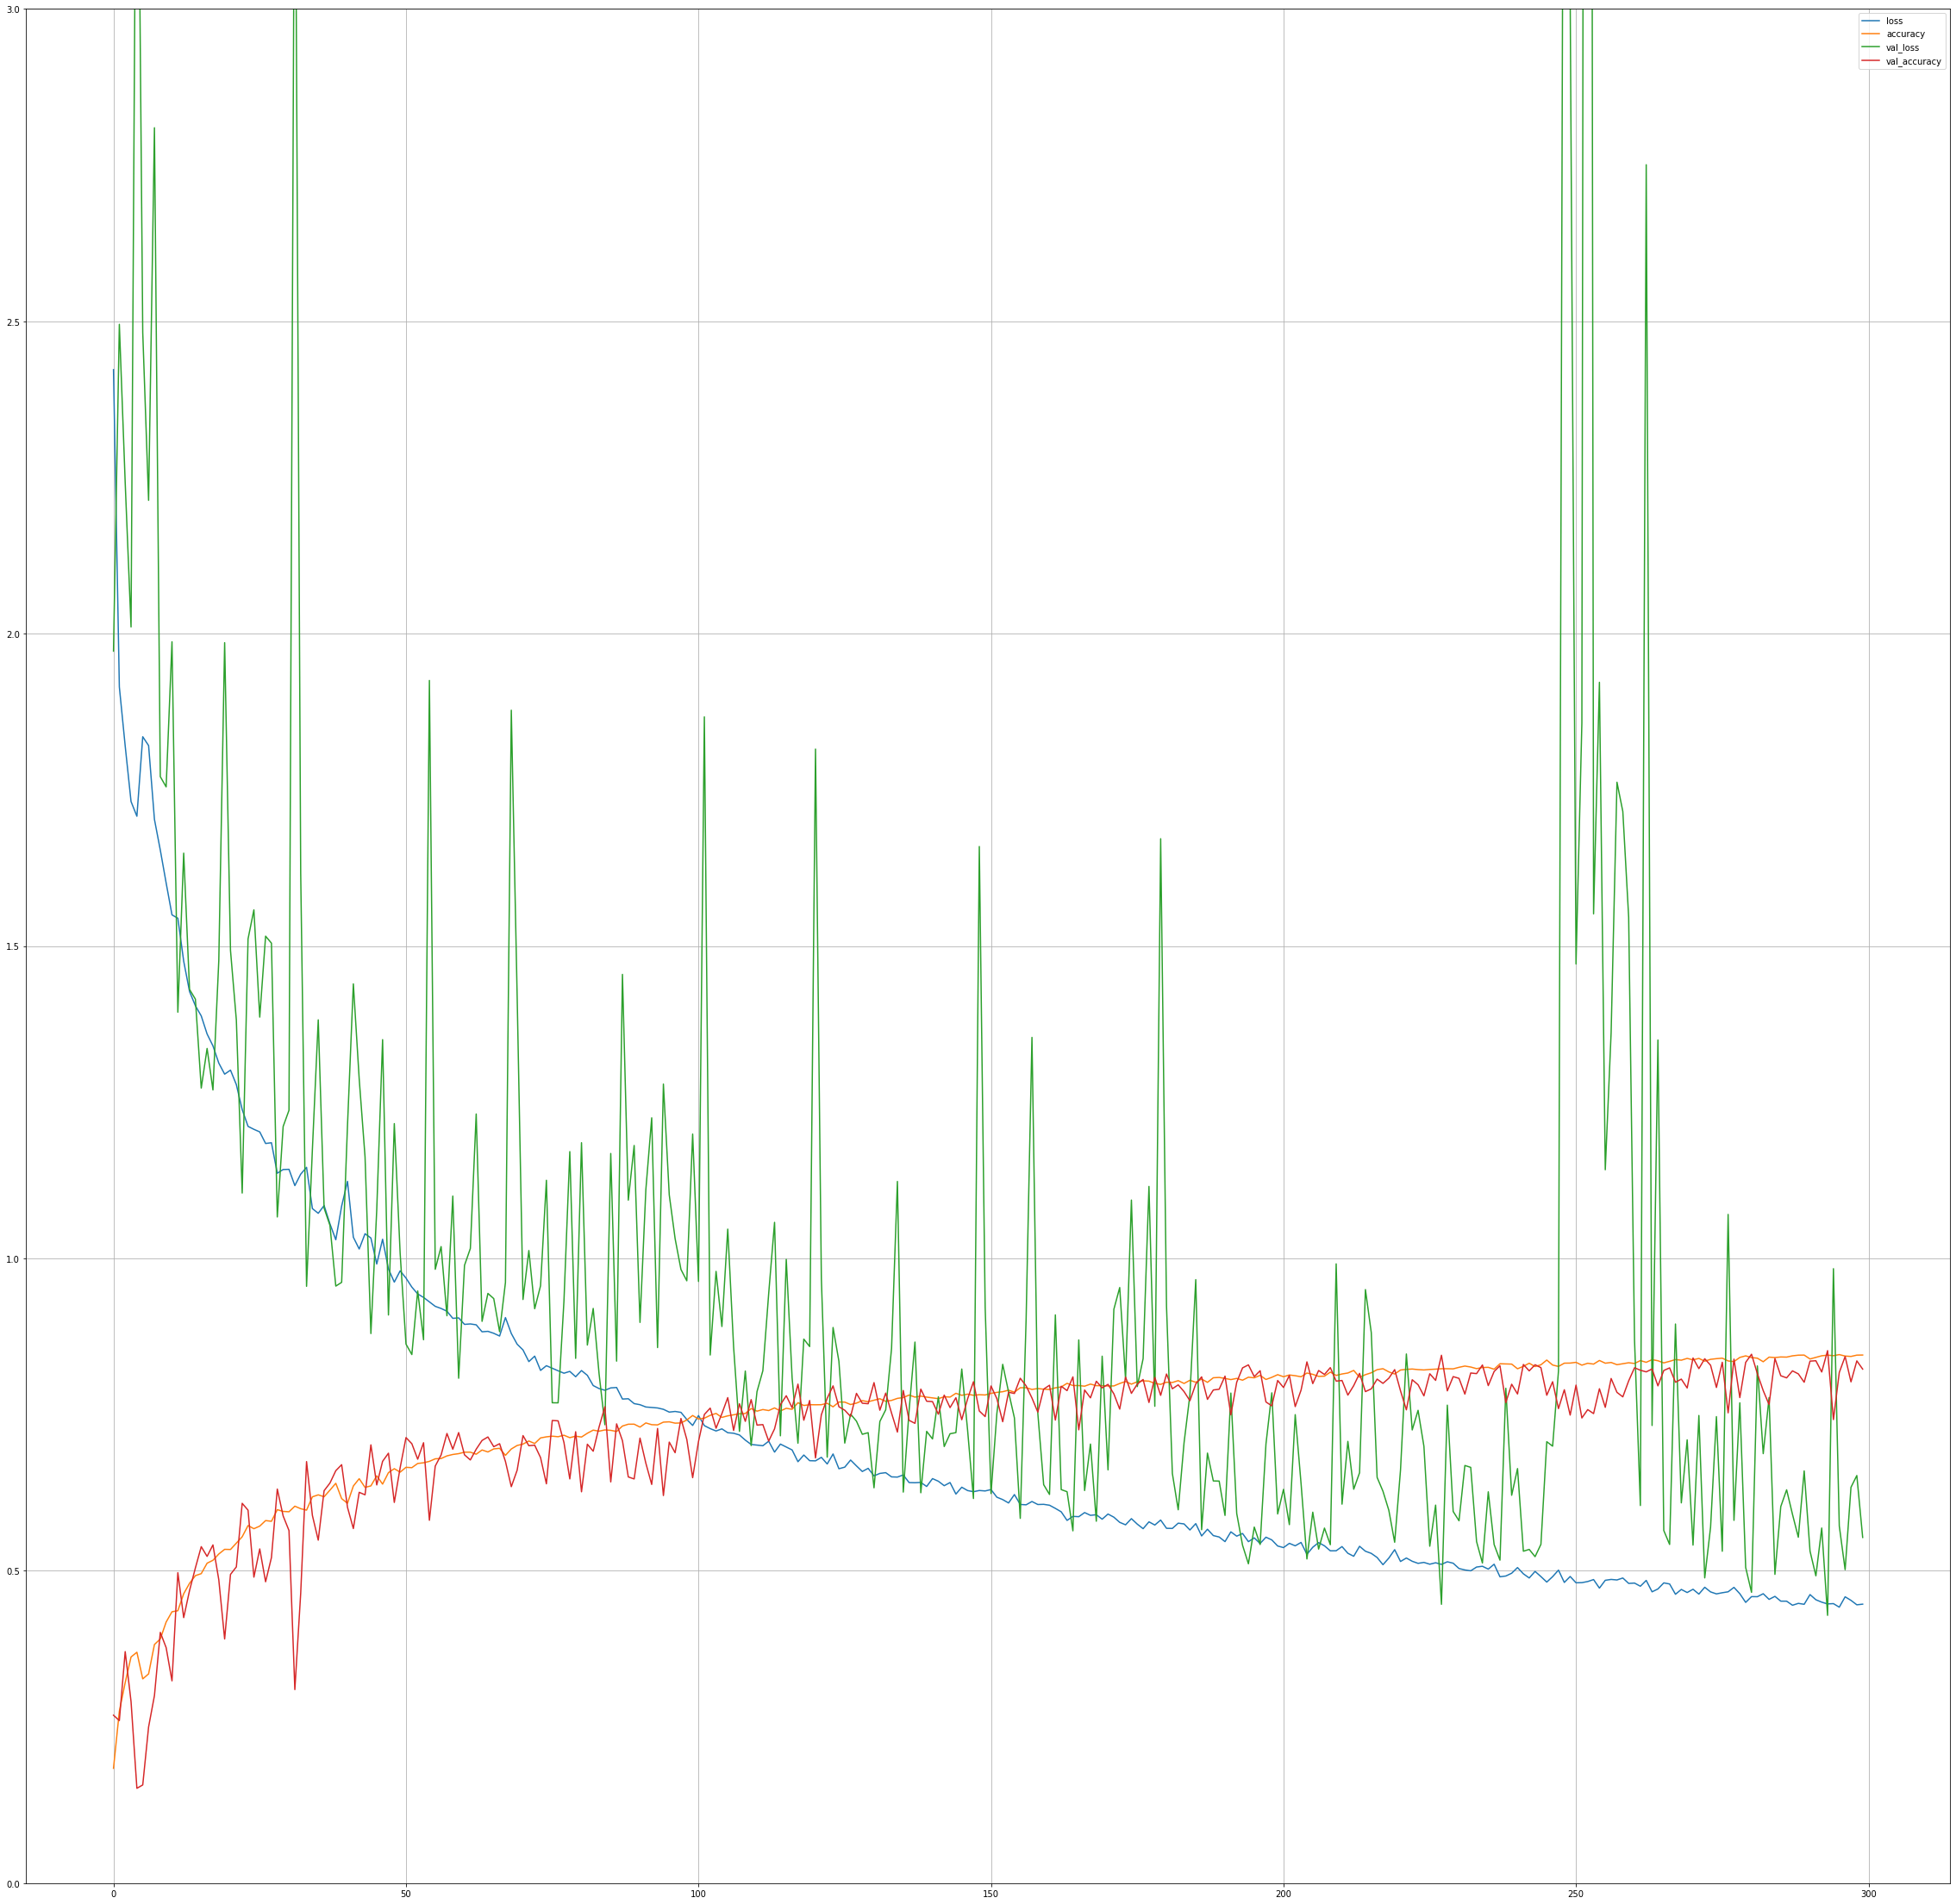

In [31]:
pd.DataFrame(history2.history).plot(figsize = (40, 40))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

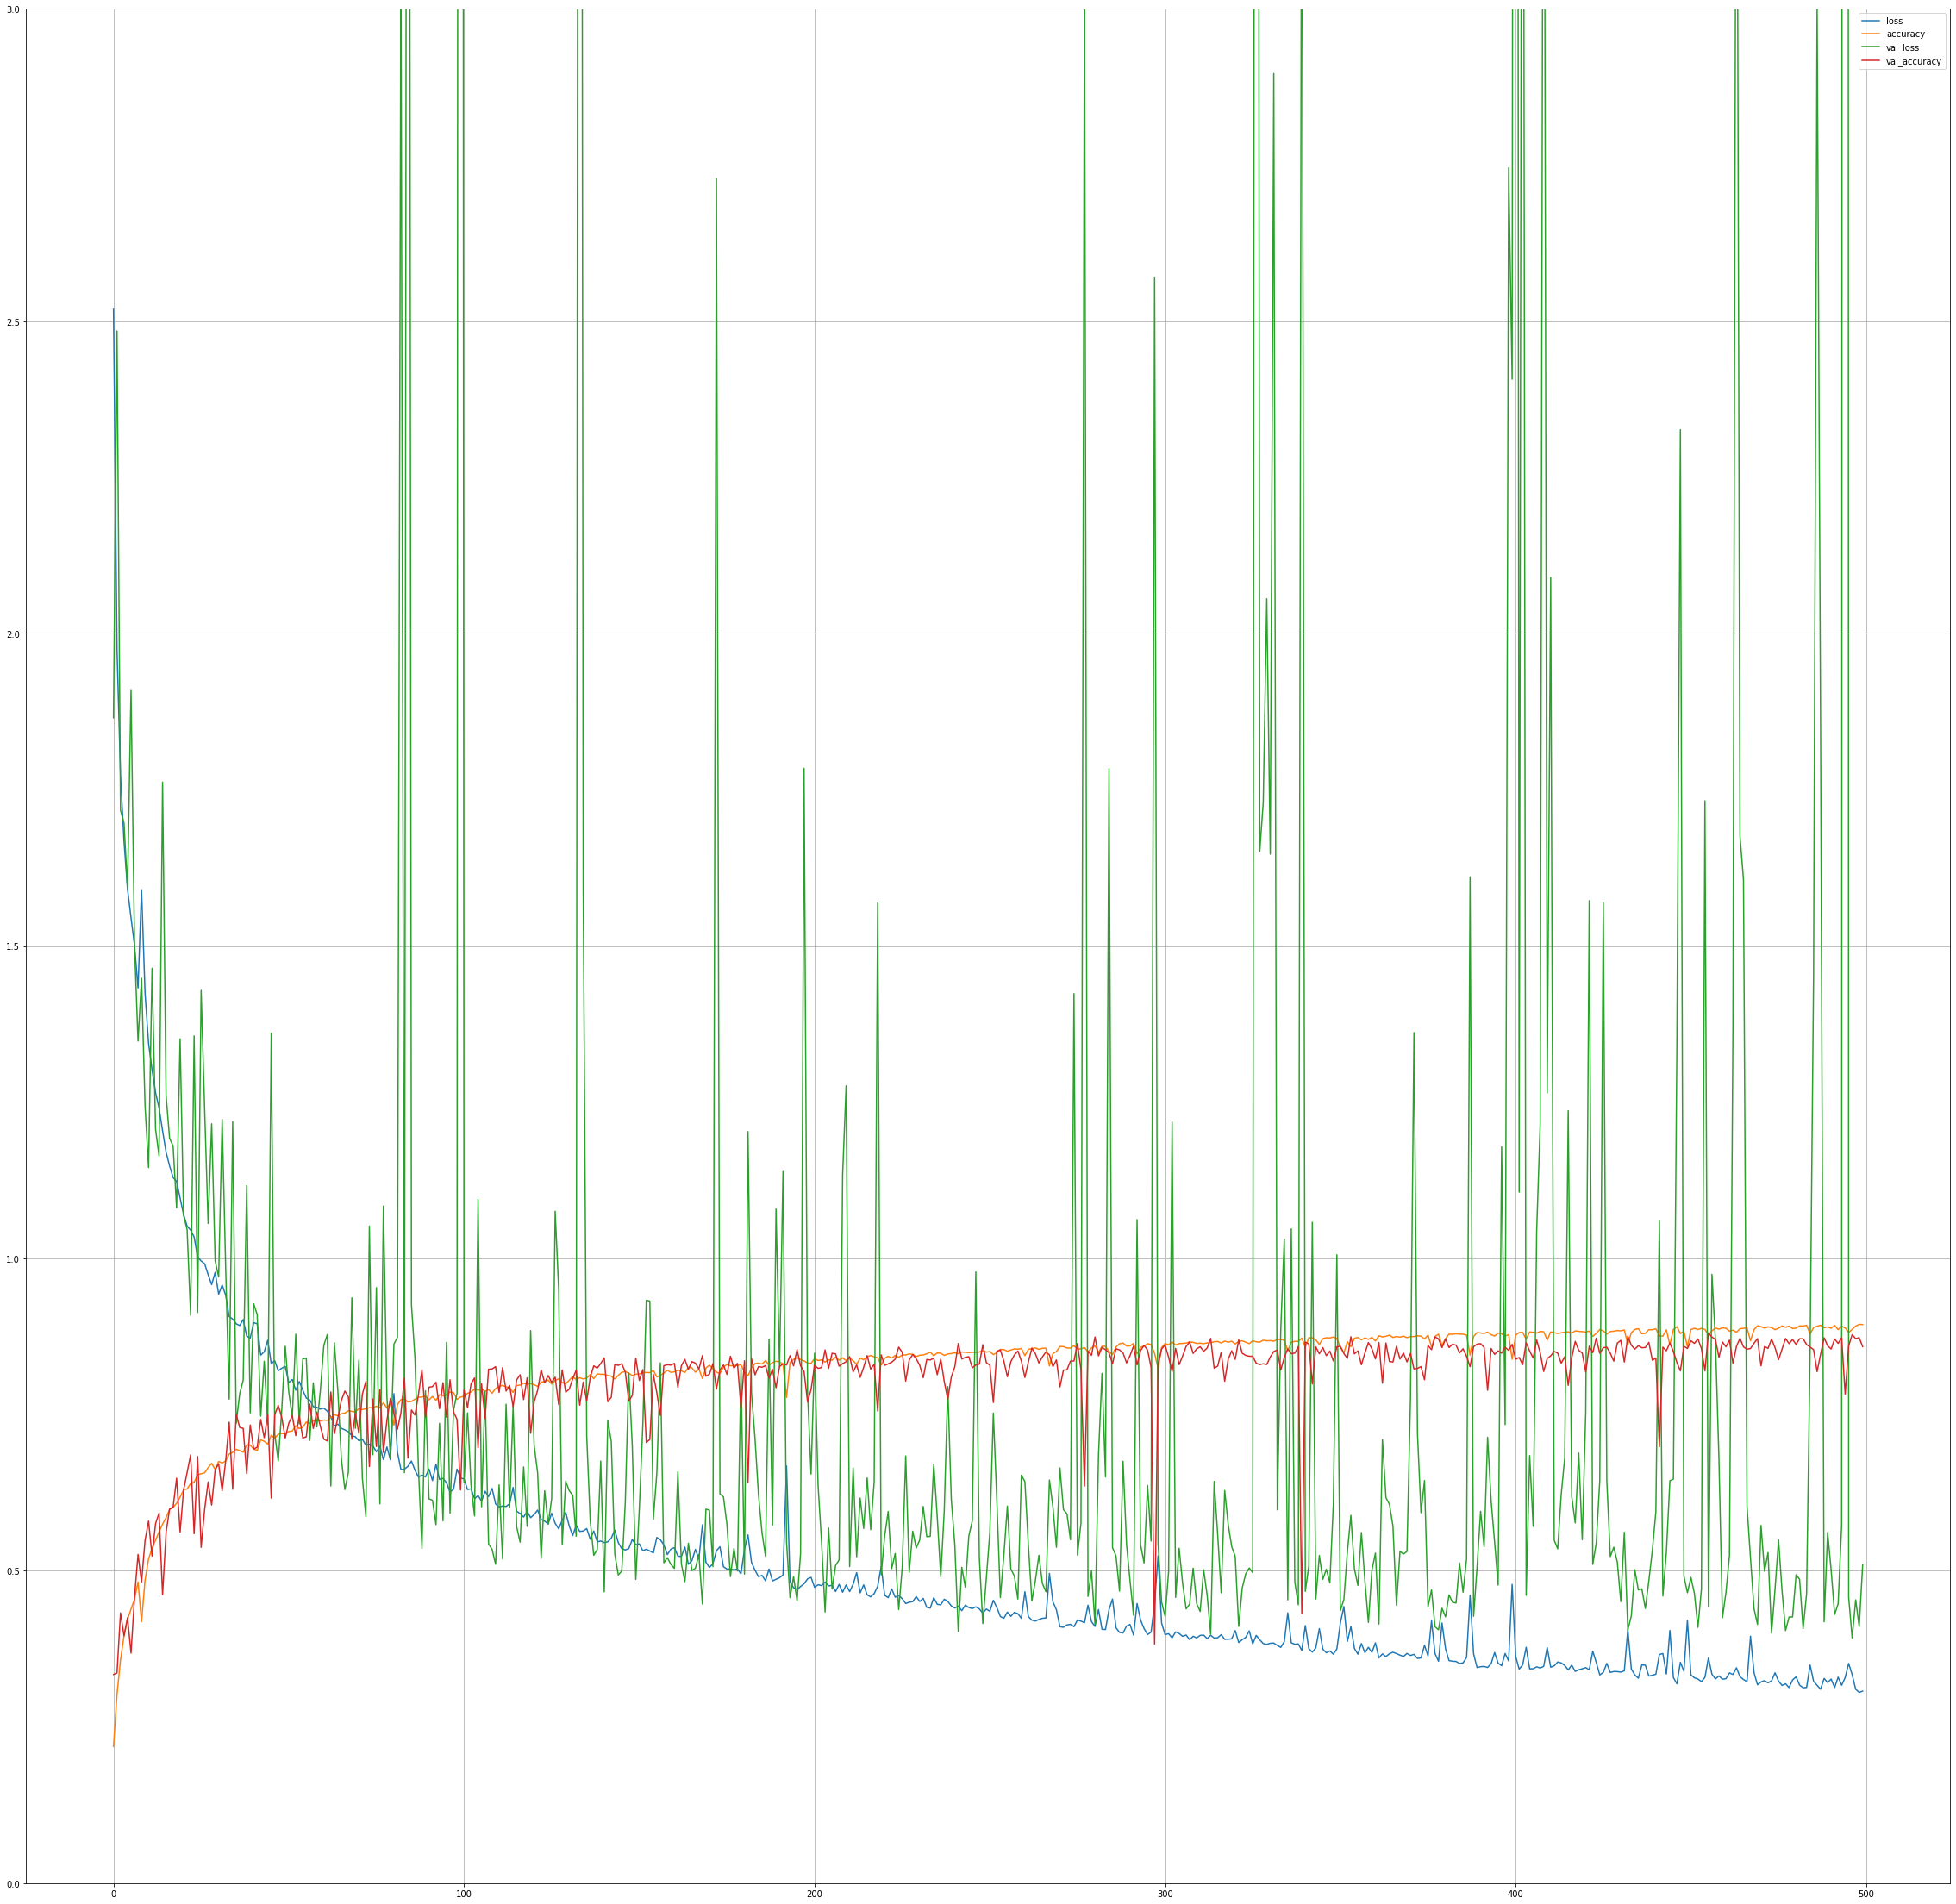

In [11]:
pd.DataFrame(history3.history).plot(figsize = (40, 40))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()